In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Setup Complete
/kaggle/input/clt-traffic-stops/Officer_Traffic_Stops.csv


# Charlotte Traffic Stops Analysis
In this notebook the city of Charlotte, North Carolina traffic stops data obtained from https://data.charlottenc.gov/datasets/officer-traffic-stops/data will be explored.

Areas of interest:
* Are women less likely to get a ticket than men?
* Are African Americans more likely to get ticketed or stopped?

The first step in exploring the database is loading the data into python. The data is in .csv format

In [4]:
stops_df = pd.read_csv("/kaggle/input/clt-traffic-stops/Officer_Traffic_Stops.csv")
stops_df.head()

,OBJECTID,Month_of_Stop,Reason_for_Stop,Officer_Race,Officer_Gender,Officer_Years_of_Service,Driver_Race,Driver_Ethnicity,Driver_Gender,Driver_Age,Was_a_Search_Conducted,Result_of_Stop,CMPD_Division,GlobalID
0,1,2020/01,Speeding,White,Male,27,White,Non-Hispanic,Female,38,No,Verbal Warning,University City Division,{00000000-0000-0000-0000-000000000000}
1,2,2019/04,Vehicle Regulatory,White,Male,4,White,Non-Hispanic,Female,25,No,Verbal Warning,Steele Creek Division,{00000000-0000-0000-0000-000000000000}
2,3,2019/08,Safe Movement,Not Specified,Male,3,Black,Non-Hispanic,Male,33,No,Verbal Warning,Independence Division,{00000000-0000-0000-0000-000000000000}
3,4,2019/10,Vehicle Regulatory,Black/African American,Male,25,Black,Non-Hispanic,Male,58,No,Verbal Warning,University City Division,{00000000-0000-0000-0000-000000000000}
4,5,2019/05,Driving While Impaired,White,Male,12,Asian,Non-Hispanic,Female,55,No,Verbal Warning,Eastway Division,{00000000-0000-0000-0000-000000000000}


Next the data needs to be cleaned. If we have null values in any of the columns it could present problems later on.

In [18]:
#stops_df[pd.isnull(stops_df.Month_of_Stop)]
print(stops_df.isnull().any())
stops_df.dropna(inplace=True)

OBJECTID                    False
Month_of_Stop               False
Reason_for_Stop             False
Officer_Race                False
Officer_Gender              False
Officer_Years_of_Service    False
Driver_Race                 False
Driver_Ethnicity            False
Driver_Gender               False
Driver_Age                  False
Was_a_Search_Conducted      False
Result_of_Stop              False
CMPD_Division               False
GlobalID                    False
dtype: bool


In [14]:
len(stops_df)

127440

From the above code we saw that there was one nan value in the dataframe. That is not significant, so we just drop that row. Next, we are going to look at all of the distinct values for driver gender.

In [15]:
stops_df.Driver_Gender.unique()

array(['Female', 'Male'], dtype=object)

We see that there are only two types of genders listed, male and female. Lets sort the dataframes by male and female, looking at the reason for stop and the result of stop columns.

In [40]:
driver_female = stops_df['Driver_Gender'] == 'Female'
driver_male = stops_df['Driver_Gender'] == 'Male'
driver_white = stops_df['Driver_Race'] == "White"

Now I want to graph the two in stacked bar charts.

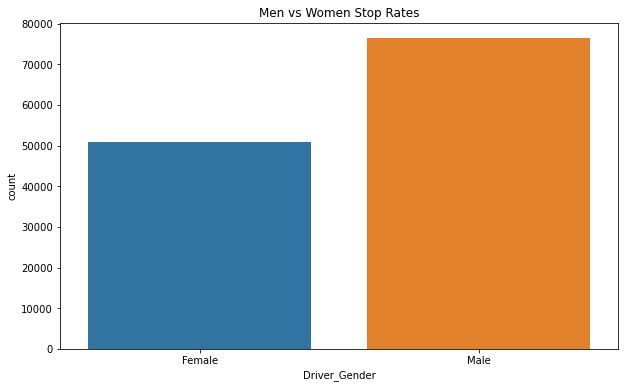

In [23]:
plt.figure(figsize=(10,6))
plt.title("Men vs Women Stop Rates")
sns.countplot(x = "Driver_Gender", data = stops_df)

Interesting. It looks like more men are stopped then women. However, could this be because there are more men in the city? We would expect a city as large as Charlotte to be roughly 50/50. Lets investigate.

From the US Census we see that Charlotte is 52% Female (https://www.census.gov/quickfacts/charlottecitynorthcarolina).

Not a drastic difference, but we should still standardize our results for population. Making a standardized graph would be doable, but more time consuming so I am just going to standardize the results

In [44]:
men_stopped = len(stops_df[driver_male])
women_stopped = len(stops_df[driver_female])

In [45]:
print("Men Stopped  : " + str(men_stopped))
print("Women Stopped: " +str(women_stopped))
print(str(men_stopped * 100/(men_stopped + women_stopped)) + "% of stops were Men")
print(str((men_stopped/women_stopped - 1)* 100) + "% more Men are stopped than Women")

Men Stopped  : 76421
Women Stopped: 51019
59.96625863151287% of stops were Men
49.78929418451949% more Men are stopped than Women


So we can see that men are stopped more than women. Specifically, men are stopped about 50% more (standardizing for demographic differences in the city of Charlotte)

Now lets look into the outcome of stops based on gender. To do this, we will again look at a barchart. However, it would be preferable to look at the chart as a percentage of stops by gender.

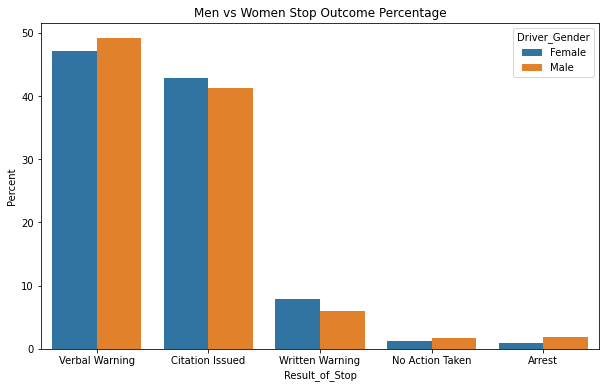

In [62]:


driver_gender_df = stops_df[driver_white].groupby("Driver_Gender")["Result_of_Stop"].value_counts(normalize=True)
driver_gender_df = driver_gender_df.mul(100)
driver_gender_df = driver_gender_df.rename("Percent").reset_index()
plt.figure(figsize=(10,6))
plt.title("Men vs Women Stop Outcome Percentage")
sns.barplot(x = "Result_of_Stop", y = "Percent" ,hue = "Driver_Gender", data = driver_gender_df)
#graph.ax.set_ylim(100)

#for p in graph.ax.patches:
#    txt = str(p.get_height().round(2)) + '%'
#    txt_x = p.get_x() 
#    txt_y = p.get_height()
#    graph.ax.text(txt_x,txt_y,txt)

It looks like it is more likely for a Female to get a Citation, while it is more likely for a Male to either get arrested, get a Verbal Warning, or have No Action Taken. This is not what was expected, but the data doesn't lie. It would be nice to be able to know a little more about the encounters. Lets review the graphs for the different types of stops. 

In [67]:
stops_type_list = stops_df.Reason_for_Stop.unique()
print(stops_type_list)

['Speeding                 ' 'Vehicle Regulatory       '
 'Safe Movement            ' 'Driving While Impaired   '
 'Stop Light/Sign          ' 'Investigation            '
 'Vehicle Equipment        ' 'Other                    '
 'SeatBelt                 ' 'CheckPoint               ']


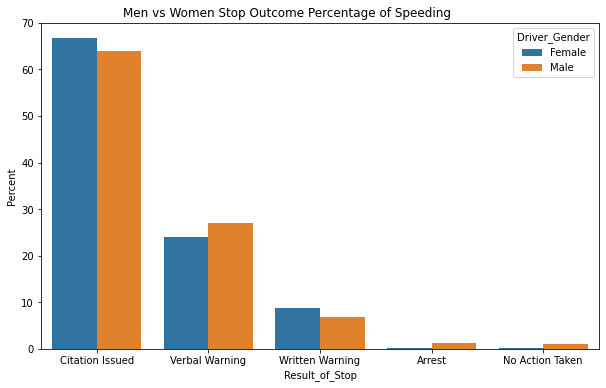

In [72]:
driver_gender_df = stops_df[stops_df.Reason_for_Stop == stops_type_list[0]].groupby("Driver_Gender")["Result_of_Stop"].value_counts(normalize=True)
driver_gender_df = driver_gender_df.mul(100)
driver_gender_df = driver_gender_df.rename("Percent").reset_index()
plt.figure(figsize=(10,6))
plt.title("Men vs Women Stop Outcome Percentage of " + str(stops_type_list[0]))
sns.barplot(x = "Result_of_Stop", y = "Percent" ,hue = "Driver_Gender", data = driver_gender_df)

So it looks like while Men get pulled over more frequently, they also get more verbal warnings. This appears consistent across multiple types of stop.

Now that we have investigated the effects of Gender on traffic stops, now lets look at Race.

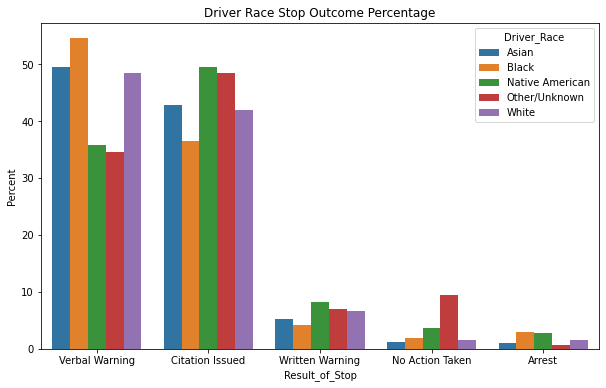

In [74]:
driver_gender_df = stops_df.groupby("Driver_Race")["Result_of_Stop"].value_counts(normalize=True)
driver_gender_df = driver_gender_df.mul(100)
driver_gender_df = driver_gender_df.rename("Percent").reset_index()
plt.figure(figsize=(10,6))
plt.title("Driver Race Stop Outcome Percentage")
sns.barplot(x = "Result_of_Stop", y = "Percent" ,hue = "Driver_Race", data = driver_gender_df)

African Americans are much more likely to get a verbal warning than other races. They are the least likely to get a citation. Lets explore this for other violations.

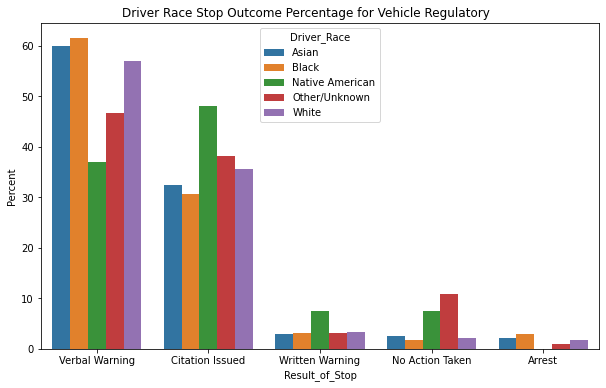

In [80]:
driver_gender_df = stops_df[stops_df.Reason_for_Stop == stops_type_list[1]].groupby("Driver_Race")["Result_of_Stop"].value_counts(normalize=True)
driver_gender_df = driver_gender_df.mul(100)
driver_gender_df = driver_gender_df.rename("Percent").reset_index()
plt.figure(figsize=(10,6))
plt.title("Driver Race Stop Outcome Percentage for " + str(stops_type_list[1]))
sns.barplot(x = "Result_of_Stop", y = "Percent" ,hue = "Driver_Race", data = driver_gender_df)

Interesting. The percentages are very different here. Lets see what percentage of stops each type of violation is per race.

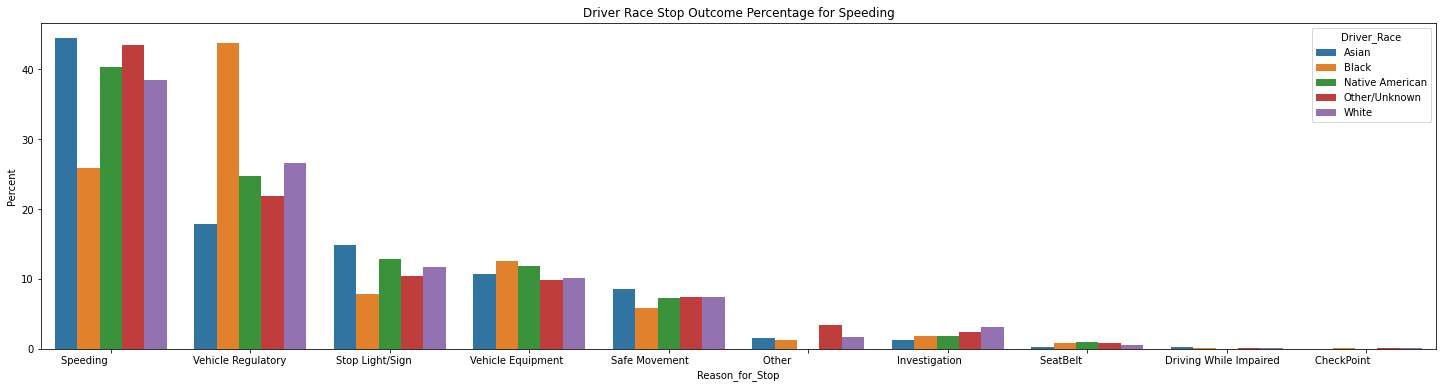

In [79]:
driver_gender_df = stops_df.groupby("Driver_Race")["Reason_for_Stop"].value_counts(normalize=True)
driver_gender_df = driver_gender_df.mul(100)
driver_gender_df = driver_gender_df.rename("Percent").reset_index()
plt.figure(figsize=(25,6))
plt.title("Driver Race Stop Outcome Percentage for Speeding")
sns.barplot(x = "Reason_for_Stop", y = "Percent" ,hue = "Driver_Race", data = driver_gender_df)

And wow, look at those regulatory stops! Something is going on there. For some reason, African Americans are about twice as likely to be stopped for regulatory reasons than the next closest group, Whites. Now, lets look into searches.

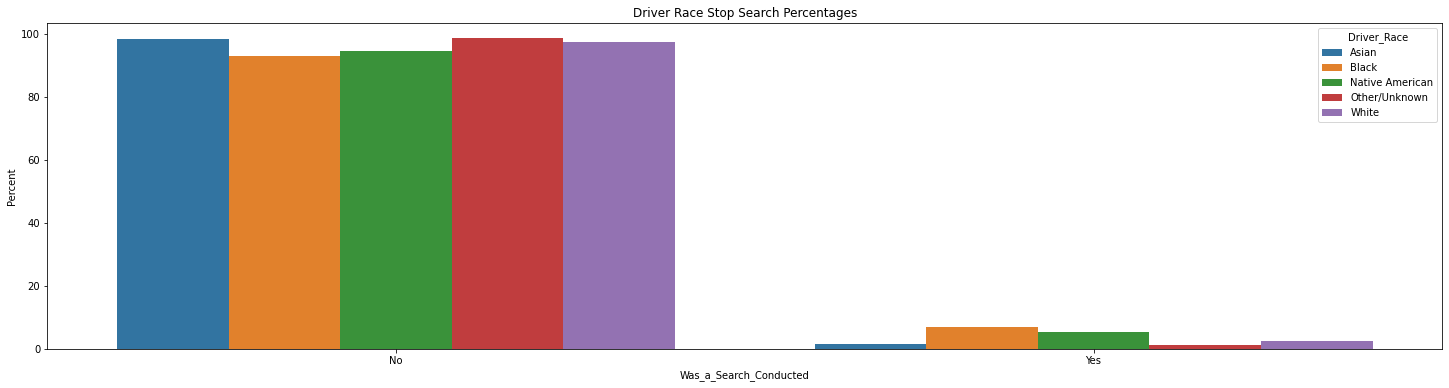

In [82]:
driver_gender_df = stops_df.groupby("Driver_Race")["Was_a_Search_Conducted"].value_counts(normalize=True)
driver_gender_df = driver_gender_df.mul(100)
driver_gender_df = driver_gender_df.rename("Percent").reset_index()
plt.figure(figsize=(25,6))
plt.title("Driver Race Stop Search Percentages")
sns.barplot(x = "Was_a_Search_Conducted", y = "Percent" ,hue = "Driver_Race", data = driver_gender_df)

In [84]:
driver_gender_df

,Driver_Race,Was_a_Search_Conducted,Percent
0,Asian,No,98.418127
1,Asian,Yes,1.581873
2,Black,No,92.935734
3,Black,Yes,7.064266
4,Native American,No,94.495413
5,Native American,Yes,5.504587
6,Other/Unknown,No,98.643928
7,Other/Unknown,Yes,1.356072
8,White,No,97.481472
9,White,Yes,2.518528


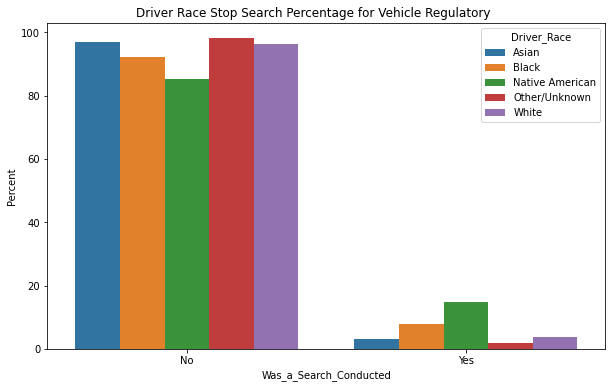

In [85]:
driver_gender_df = stops_df[stops_df.Reason_for_Stop == stops_type_list[1]].groupby("Driver_Race")["Was_a_Search_Conducted"].value_counts(normalize=True)
driver_gender_df = driver_gender_df.mul(100)
driver_gender_df = driver_gender_df.rename("Percent").reset_index()
plt.figure(figsize=(10,6))
plt.title("Driver Race Stop Search Percentage for " + str(stops_type_list[1]))
sns.barplot(x = "Was_a_Search_Conducted", y = "Percent" ,hue = "Driver_Race", data = driver_gender_df)